Links:
 - https://en.wikipedia.org/wiki/Spherical_geometry
 - https://en.wikipedia.org/wiki/List_of_map_projections
 - https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
 - https://en.wikipedia.org/wiki/Xiaolin_Wu's_line_algorithm
 - https://brsr.github.io/2021/05/01/vector-spherical-geometry.html
 - https://mathworld.wolfram.com/GreatCircle.html
 - https://geographiclib.sourceforge.io/html/js/tutorial-3-examples.html#waypoints
 - http://www.movable-type.co.uk/scripts/latlong.html
 - https://geographiclib.sourceforge.io/html/js/index.html
 - https://mathoverflow.net/questions/247284/clairauts-relation-and-the-equation-of-great-circle-in-spherical-coordinates
 - https://mathworld.wolfram.com/GnomonicProjection.html
 - https://en.wikipedia.org/wiki/Rhumb_line

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def spherical_to_cartesian(lat, lon, rad = 1):
    x = rad*np.sin(lat)*np.cos(lon)
    y = rad*np.sin(lat)*np.sin(lon)
    z = rad*np.cos(lat)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = np.linalg.norm((x, y, z))
    lat = np.arccos(z/r)
    lon = np.sign(y)*np.arccos(x/np.linalg.norm((x, y)))
    return r, lat, lon
 
def great_circle_distance(lat_0, lon_0, lat_1, lon_1): # Why do lat and lon need to be swapped for this to work?
    return np.arccos(np.sin(lat_0)*np.sin(lat_1) + np.cos(lat_0)*np.cos(lat_1)*np.cos(lon_0 - lon_1))

def great_circle_angle(lat_0, lon_0, lat_1, lon_1):
    # angle counterclockwise from north pole
    p_ref = (np.pi/2, 0)
    p_0 = (lat_0, lon_0)
    p_1 = (lat_1, lon_1)
    d_0_ref = great_circle_distance(*p_0, *p_ref)
    d_1_ref = great_circle_distance(*p_1, *p_ref)
    d_0_1 = great_circle_distance(*p_0, *p_1)
    arg = (np.cos(d_1_ref) - np.cos(d_0_ref)*np.cos(d_0_1))/(np.sin(d_0_ref)*np.sin(d_0_1))
    arg = np.where(arg < -1, -1, arg)
    arg = np.where(arg > 1, 1, arg)
    angle = np.arccos(arg)
    if lon_0 >= 0:
        condition = np.logical_or((lon_1 > lon_0), (lon_1 <= lon_0 - np.pi))
    elif lon_0 < 0:
        condition = np.logical_and((lon_1 > lon_0), (lon_1 <= lon_0 + np.pi))
    return np.where(condition, 2*np.pi - angle, angle) + np.pi/2

def move_point(lat_0, lon_0, angle, distance):
    lat_1 = np.arcsin(np.sin(lat_0)*np.cos(distance) + np.cos(lat_0)*np.sin(distance)*np.cos(angle))
    lon_1 = lon_0 + np.arctan2(np.sin(angle)*np.sin(distance)*np.cos(lat_0), np.cos(distance) - np.sin(lat_0)*np.sin(lat_1))
    if lat_1 < -np.pi/2:
        lat_1 = np.pi/2 - np.abs(lat_1)%(np.pi/2)
    elif lat_1 > np.pi/2:
        lat_1 = lat_1%(np.pi/2) - np.pi/2
    if lon_1 < -np.pi:
        lon_1 = np.pi - np.abs(lon_1)%np.pi
    elif lon_1 > np.pi:
        lon_1 = lon_1%np.pi - np.pi
    return lat_1, lon_1

def logistic(x, L = 1, k = 1, x_0 = 0):
    return np.where(~np.isnan(x), L/(1 + np.exp(-k*(x - x_0))), np.nan)

In [60]:
class Plume:
    def __init__(self, coordinates, mask, position, strength, radius):
        self.coordinates = coordinates.copy()
        self.mask = mask.copy()
        self.position = position
        self.strength = strength
        self.radius = radius
        self.distance = np.where(self.mask, great_circle_distance(*self.position, *self.coordinates), np.nan)
        self.angle = np.where(self.mask, great_circle_angle(*self.position, *self.coordinates), np.nan)
        self.force = np.where(np.logical_and(self.mask, self.distance >= self.radius), self.strength/self.distance, np.nan)*np.array([np.sin(self.angle), np.cos(self.angle)])
    
    def update(self):
        self.distance = np.where(self.mask, great_circle_distance(*self.position, *self.coordinates), np.nan)
        self.angle = np.where(self.mask, great_circle_angle(*self.position, *self.coordinates), np.nan)
        self.force = np.where(np.logical_and(self.mask, self.distance >= self.radius), self.strength/self.distance, np.nan)*np.array([np.sin(self.angle), np.cos(self.angle)])

class Plate:
    def __init__(self, coordinates, mask):
        self.mask = mask
        self.coordinates = np.where(np.tile(mask, (2, 1, 1)), coordinates, np.nan)
        self.indices = np.nonzero(mask)

In [61]:
image_shape = (128, 256)
no_gridlines = (5, 5)
gridline_thickness = 2
no_plumes = 8
seed = 1

In [211]:
rng = np.random.default_rng(seed = seed)

# Calculate number of longitudinal samples for each latitude and define a mask
no_points = points_around_sphere(image_shape)
mask = np.zeros(image_shape, dtype = bool)
for points_index, points in enumerate(no_points):
    lower = np.floor(image_shape[1]/2 - points/2).astype(int)
    upper = np.ceil(image_shape[1]/2 + points/2).astype(int)
    mask[points_index, lower:upper] = True

coordinates = np.zeros((2, *image_shape))
for column_index in range(image_shape[1]):
    column = coordinates[0, :, column_index]
    # column[mask[:, column_index]] = np.linspace(np.pi/2, -np.pi/2, mask[:, column_index].sum()) # linspace defined with no. elements equal to no. True pixels in mask for each row
    column[mask[:, column_index]] = np.linspace(-np.pi/2, np.pi/2, image_shape[0])[mask[:, column_index]] # linspace defined for entire row, but only subset of elements where row is True used
for row_index in range(image_shape[0]):
    row = coordinates[1, row_index, :]
    row[mask[row_index, :]] = np.linspace(-np.pi, np.pi, mask[row_index, :].sum())
    # row[mask[row_index, :]] = np.linspace(0, 2*np.pi, image_shape[1])[mask[row_index, :]]
coordinates = np.where(np.tile(mask, (2, 1, 1)), coordinates, np.nan)

mask_1 = np.full(image_shape, True)

coordinates_1 = np.zeros((2, *image_shape))
for column_index in range(image_shape[1]):
    column = coordinates_1[0, :, column_index]
    # column[mask[:, column_index]] = np.linspace(np.pi/2, -np.pi/2, mask[:, column_index].sum()) # linspace defined with no. elements equal to no. True pixels in mask for each row
    column[mask_1[:, column_index]] = np.linspace(-np.pi/2, np.pi/2, image_shape[0])[mask_1[:, column_index]] # linspace defined for entire row, but only subset of elements where row is True used
for row_index in range(image_shape[0]):
    row = coordinates_1[1, row_index, :]
    row[mask_1[row_index, :]] = np.linspace(-np.pi, np.pi, mask_1[row_index, :].sum())
    # row[mask[row_index, :]] = np.linspace(0, 2*np.pi, image_shape[1])[mask[row_index, :]]
coordinates_1 = np.where(np.tile(mask_1, (2, 1, 1)), coordinates_1, np.nan)

# lines_lat = np.linspace(-np.pi/2, np.pi/2, no_gridlines[0]) # coordinates of vertical (latitudinal) lines
# lines_lon = np.linspace(-np.pi, np.pi, no_gridlines[1]) # coordinates of horizontal (longitudinal) lines
# grid = np.full((2, *image_shape), False)
# for column_index in range(image_shape[1]):
#     for line in lines_lat:
#         distances = np.where(mask[:, column_index], np.abs(coordinates[0, :, column_index] - line), np.nan) # Distance from each pixel in the given column to the current longitudinal line, excluding pixels outside mask
#         row_indices = np.argpartition(distances, gridline_thickness)[:gridline_thickness] # Indices of the k shortest distances
#         grid[0, row_indices, column_index] = True
# for row_index in range(image_shape[0]):
#     for line in lines_lon:
#         distances = np.where(mask[row_index, :], np.abs(coordinates[1, row_index, :] - line), np.nan) # Distance from each pixel in the given row to the current latitudinal line, excluding pixels outside mask
#         column_indices = np.argpartition(distances, gridline_thickness)[:gridline_thickness] # Indices of the k shortest distances
#         grid[1, row_index, column_indices] = True

plumes = [Plume(coordinates, mask, np.array([rng.uniform(-np.pi/2, np.pi/2), rng.uniform(-np.pi, np.pi)]), rng.uniform(1, 2), rng.uniform(0.01, 0.02)) for _ in range(no_plumes)]
force_map = np.linalg.norm(np.array([plume.force for plume in plumes]), axis = 1).sum(0)
# plates = np.array([np.where(np.array([plume.distance for plume in plumes]).argmin(0) == plume_index, True, False) for plume_index in range(len(plumes))])
plates = [Plate(coordinates, (np.array([plume.distance for plume in plumes]).argmin(0) == index)*mask) for index in range(no_plumes)]
# plumes = {"coordinates" : np.stack([rng.uniform(-np.pi/2, np.pi/2, no_plumes), rng.uniform(-np.pi, np.pi, no_plumes)], 1),
#           "strength" : rng.uniform(1, 100, no_plumes),
#           "radius" : rng.uniform(0.01, 0.05, no_plumes),
#           "distance" : np.zeros((no_plumes, *image_shape)),
#           "angle" : np.zeros((no_plumes, *image_shape)),
#           "force" : np.zeros((no_plumes, 2, *image_shape)),
#           "nearest" : np.zeros((no_plumes, *image_shape)),
#           "dominant" : np.zeros((no_plumes, *image_shape))}
# for plume_index in range(no_plumes):
#     plumes["distance"][plume_index] = np.where(mask, great_circle_distance(*plumes["coordinates"][plume_index], *coordinates), np.nan)
#     plumes["angle"][plume_index] = np.where(mask, great_circle_angle(*plumes["coordinates"][plume_index], *coordinates), np.nan)
#     force = np.where(mask, np.where(plumes["distance"][plume_index] >= plumes["radius"][plume_index], plumes["strength"][plume_index]/plumes["distance"][plume_index], 0), np.nan)
#     plumes["force"][plume_index] = force*np.stack([np.sin(plumes["angle"][plume_index]), np.cos(plumes["angle"][plume_index])])
# for plume_index in range(no_plumes):
#     plumes["nearest"][plume_index] = np.where(plumes["distance"].argmin(0) == plume_index, True, False)
#     plumes["dominant"][plume_index] = np.where(np.linalg.norm(plumes["force"], axis = 1).argmax(0) == plume_index, True, False)

In [62]:
rng = np.random.default_rng(seed = seed)

no_points = (np.cos(np.linspace(-np.pi/2, np.pi/2, image_shape[0]))*image_shape[1] + 1).astype(int)
mask = np.zeros(image_shape, dtype = bool)
for index, points in enumerate(no_points):
    mask[index, image_shape[1]//2 - points//2:image_shape[1]//2 + points//2 + points%2] = True

coordinates = np.zeros((2, *image_shape))
for column_index in range(image_shape[1]):
    column = coordinates[0, :, column_index]
    column[mask[:, column_index]] = np.linspace(-np.pi/2, np.pi/2, image_shape[0], endpoint = False)[mask[:, column_index]]
for row_index in range(image_shape[0]):
    row = coordinates[1, row_index, :]
    row[mask[row_index, :]] = np.linspace(-np.pi, np.pi, mask[row_index, :].sum(), endpoint = False)
coordinates = np.where(np.tile(mask, (2, 1, 1)), coordinates, np.nan)

plumes = [Plume(coordinates, mask, np.array([rng.uniform(-np.pi/2, np.pi/2), rng.uniform(-np.pi, np.pi)]), rng.uniform(1, 2), rng.uniform(0.01, 0.02)) for _ in range(no_plumes)]
plates = [Plate(coordinates, (np.array([plume.distance for plume in plumes]).argmin(0) == index)*mask) for index in range(no_plumes)]

In [6]:
def generate_connectivity(point, mask):
    if np.isnan(mask[*point]):
        connectivity = np.full((3, 3), np.nan)
    else:
        connectivity = np.array(np.meshgrid([-1, 0, 1], [-1, 0, 1])).T.reshape(-1, 2) + point
        connectivity[:, 0][connectivity[:, 0] == -1] = 0
        connectivity[:, 0][connectivity[:, 0] == mask.shape[0]] = mask.shape[0] - 1
        connectivity[:, 1] %= mask.shape[1]
        offset_values = np.array([mask[*offset] for offset in connectivity])
        if not offset_values[0]:
            connectivity[0, 0] += 1
            connectivity[0, 1] = mask.shape[1] - connectivity[0, 1]
        if not offset_values[1]:
            connectivity[1, 0] += 1
            connectivity[1, 1] = mask.shape[1] - connectivity[1, 1]
        if not offset_values[2]:
            connectivity[2, 0] += 1
            connectivity[2, 1] = mask.shape[1] - connectivity[2, 1]
        if not offset_values[3]:
            connectivity[3, 1] = mask.shape[1] - connectivity[3, 1]
        if not offset_values[5]:
            connectivity[5, 1] = mask.shape[1] - connectivity[5, 1]
        if not offset_values[6]:
            connectivity[6, 0] -= 1
            connectivity[6, 1] = mask.shape[1] - connectivity[6, 1]
        if not offset_values[7]:
            connectivity[7, 0] -= 1
            connectivity[7, 1] = mask.shape[1] - connectivity[7, 1]
        if not offset_values[8]:
            connectivity[8, 0] -= 1
            connectivity[8, 1] = mask.shape[1] - connectivity[8, 1]
    connectivity[:, 1] %= mask.shape[1]
    return connectivity

connectivity = np.array([generate_connectivity(point, mask) for point in np.argwhere(mask)])

m = mask.copy().astype(int)
for point in connectivity[9607 - 512]:
    m[*point] = 2
plt.imshow(m)

### Coordinate transforms

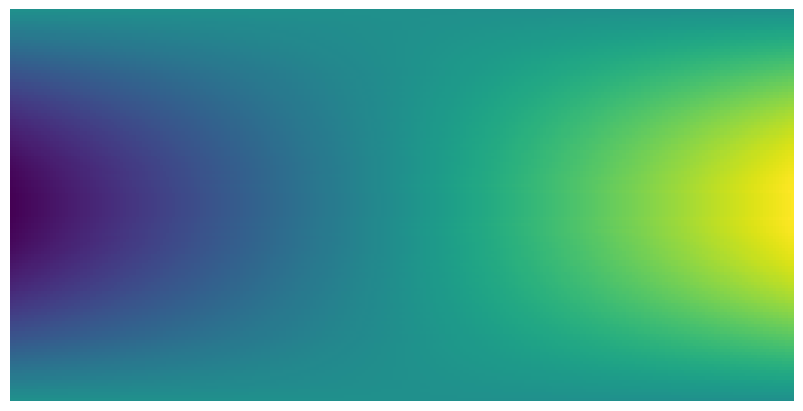

In [34]:
def rectangular_transform(mask):
    indices_output = np.zeros(mask.shape, dtype = int)
    for row_mask, row_indices in zip(mask, indices_output):
        indices = np.argwhere(row_mask)
        split_indices = np.linspace(0, row_indices.size, indices.size + 1).astype(int)[1:]
        bins = np.split(row_indices, split_indices)[:-1]
        for bin, index in zip(bins, indices):
            bin[:] = index
    return indices_output

figure, axis = plt.subplots(1, 1, figsize = (8, 4), layout = "constrained")
axis.imshow(rectangular_transform(mask))
axis.axis(False)
plt.show()

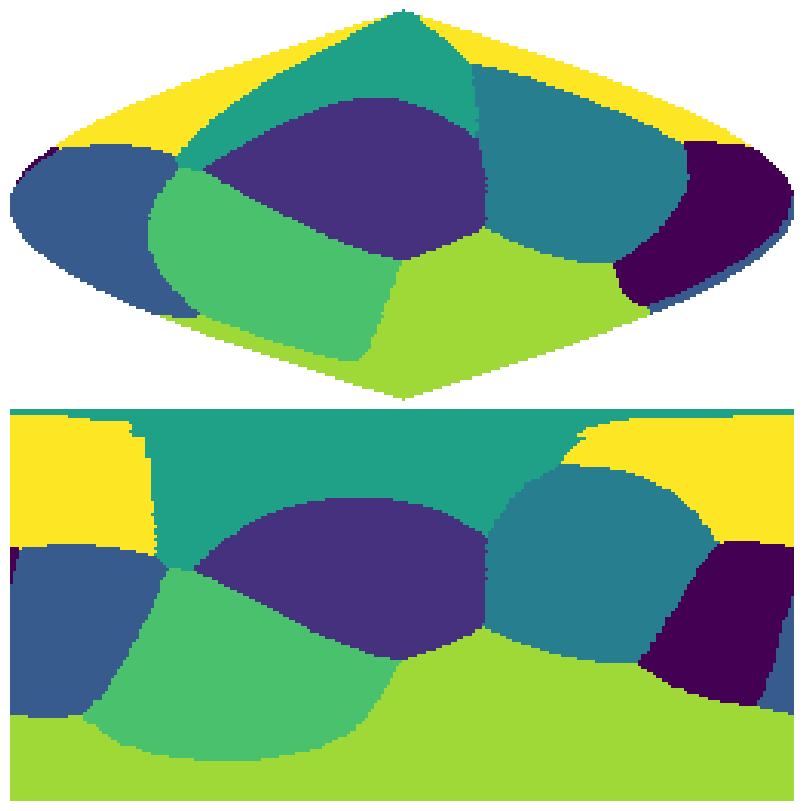

In [63]:
mask_input = np.where(mask, np.array([plate.mask*index for index, plate in enumerate(plates)]).sum(0), np.nan)
transform = rectangular_transform(~np.isnan(mask_input))
mask_output = np.zeros_like(mask_input)
for index in np.ndindex(mask_output.shape):
    mask_output[index] = mask_input[index[0], transform[*index]]

images = np.array([mask_input, mask_output])
figure, axes = plt.subplots(images.shape[0], 1, figsize = (8, 4*images.shape[0]), layout = "constrained")
for axis, image in zip(axes, images):
    axis.imshow(image)
    axis.axis(False)

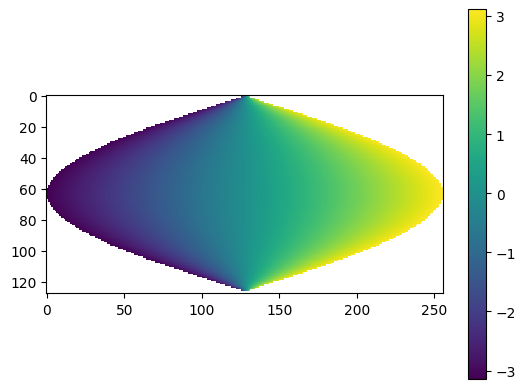

In [64]:
plt.imshow(coordinates[1])
plt.colorbar()

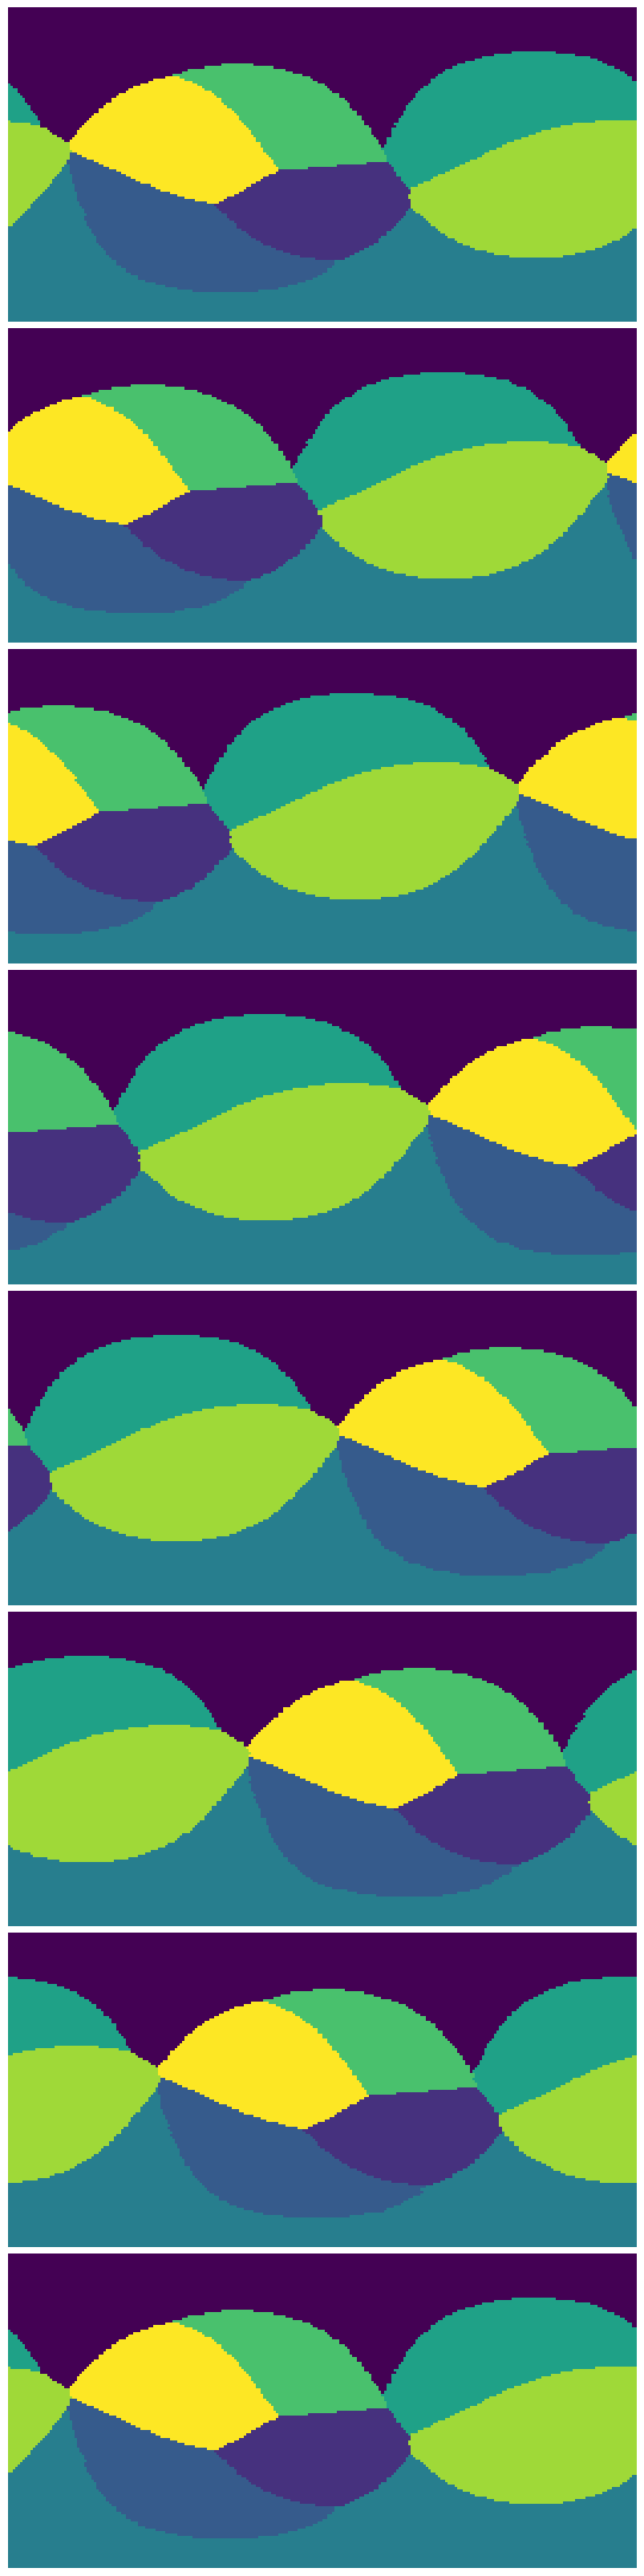

In [67]:
def generate_rectangular_mask(mask):
    transform = rectangular_transform(~np.isnan(mask))
    mask_output = np.zeros_like(mask)
    for index in np.ndindex(mask_output.shape):
        mask_output[index] = mask[index[0], transform[*index]]
    return mask_output

masks = []

plumes = [Plume(coordinates, mask, np.array([rng.uniform(-np.pi/2, np.pi/2), rng.uniform(-np.pi, np.pi)]), rng.uniform(1, 2), rng.uniform(0.01, 0.02)) for _ in range(no_plumes)]
plates = [Plate(coordinates, (np.array([plume.distance for plume in plumes]).argmin(0) == index)*mask) for index in range(no_plumes)]

mask_input_0 = np.where(mask, np.array([plate.mask*index for index, plate in enumerate(plates)]).sum(0), np.nan)
mask_0 = mask_input_0#generate_rectangular_mask(mask_input_0)
mask_0 = plumes[0].distance
mask_0 = generate_rectangular_mask(mask_input_0)

masks.append(mask_0)

for _ in range(7):
    for plume in plumes:
        plume.coordinates[1, ...] += 2*np.pi/7
        # plume.position = move_point(*plume.position, np.pi, np.pi/15)
        plume.update()
    plates = [Plate(coordinates, (np.array([plume.distance for plume in plumes]).argmin(0) == index)*mask) for index in range(no_plumes)]
    mask_input_1 = np.where(mask, np.array([plate.mask*index for index, plate in enumerate(plates)]).sum(0), np.nan)
    mask_1 = mask_input_1#generate_rectangular_mask(mask_input_1)
    mask_1 = plumes[0].distance
    mask_1 = generate_rectangular_mask(mask_input_1)
    masks.append(mask_1)

images = np.array(masks)
figure, axes = plt.subplots(images.shape[0], 1, figsize = (8, 4*images.shape[0]), layout = "constrained")
for axis, image in zip(axes, images):
    axis.imshow(image)
    axis.axis(False)

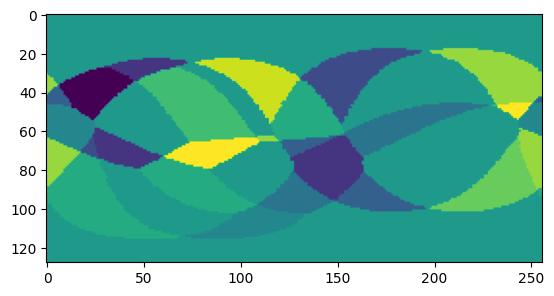

In [72]:
plt.figure()
plt.imshow(masks[0] - masks[1])

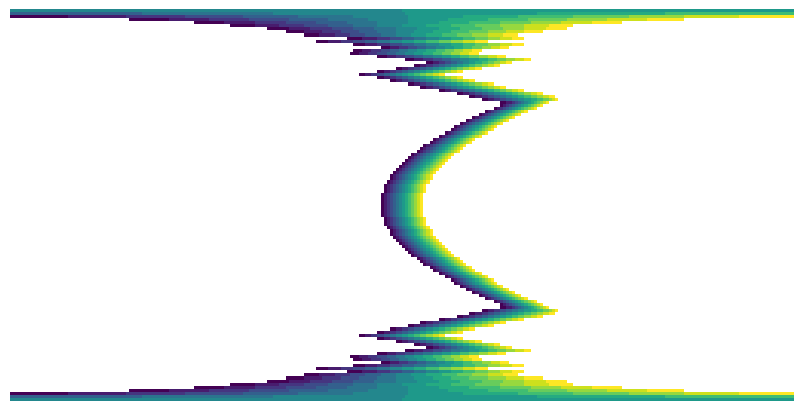

In [55]:
# This doesn't do what it's supposed to be it does look cool!

coordinates_sin_x = coordinates[1]
coordinates_rectangular_x = np.ones(coordinates_sin_x.shape)
for row_sin, row_rectangular in zip(coordinates_sin_x, coordinates_rectangular_x):
    indices = np.argwhere(~np.isnan(row_sin))
    elements = row[indices]
    number_elements = elements.size
    bins = np.array_split(row_rectangular, number_elements)
    for bin, element in zip(bins, elements):
        bin *= element

figure, axis = plt.subplots(1, 1, figsize = (8, 4), layout = "constrained")
axis.imshow(coordinates_rectangular_x)
axis.axis(False)
plt.show()

### Miscellaneous

point 0 is plume centre, point 1 is a given point on the sphere's surface

define the great circle passing through both points

use the acceleration field along this line to determine whether or not an object (newly formed crust) could have travelled from point 0 to point 1 in the given length of time


You should define force as a function of distance and angle for each plume, then you can just take the integral of this function along a great circle from point 0 to point 1 and us that to see if object could have reach 1 from 0

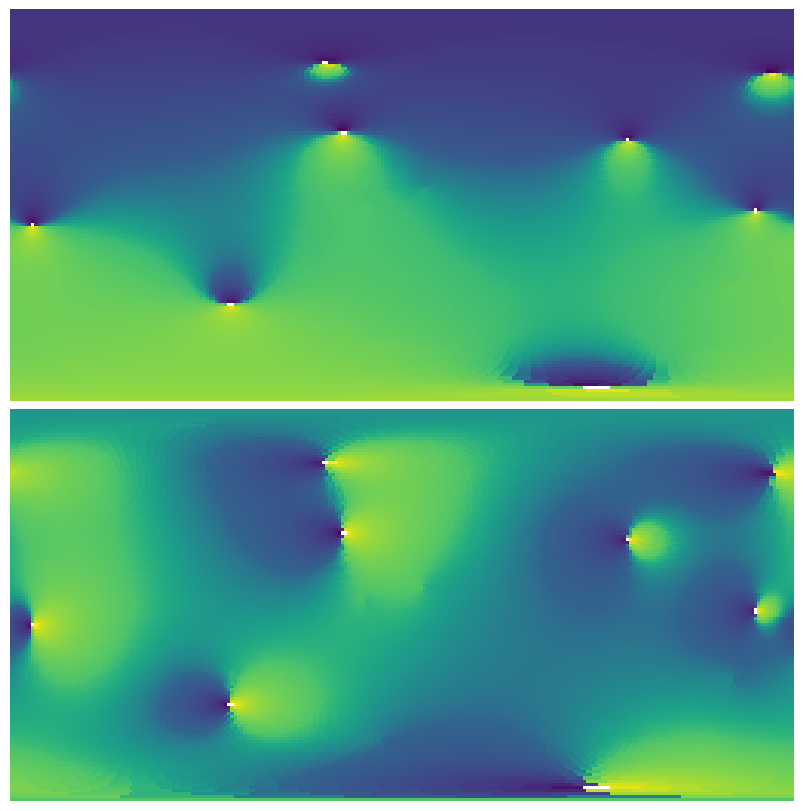

In [14]:
forces = np.array([plume.force for plume in plumes]).sum(0)
images = np.array([forces[0], forces[1]])
figure, axes = plt.subplots(images.shape[0], 1, figsize = (8, 4*images.shape[0]), layout = "constrained")
for axis, image in zip(axes, images):
    image_output = np.zeros_like(mask_input)
    for index in np.ndindex(image_output.shape):
        image_output[index] = image[index[0], transform[*index]]
    axis.imshow(image_output, norm = "symlog")
    axis.axis(False)
plt.show()

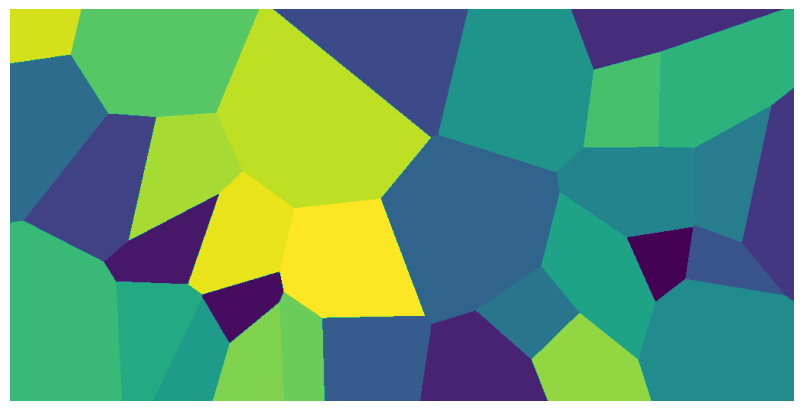

In [15]:
def voronoi(centres, coordinates):
    distances = np.array([[np.linalg.norm(centre - coordinate) for coordinate in coordinates] for centre in centres])
    return distances.argmin(axis = 0)

no_centres = 32
image = np.zeros((512, 1024))
centres = np.array([rng.uniform(0, image.shape[0], no_centres), rng.uniform(0, image.shape[1], no_centres)]).T
# centres = np.array([rng.normal(image.shape[0]/2, image.shape[0]/6, no_centres), rng.normal(image.shape[1]/2, image.shape[1]/6, no_centres)]).T
coordinates = np.array([index for index in np.ndindex(image.shape)])
values = voronoi(centres, coordinates)
for index, coordinate in enumerate(coordinates):
    image[coordinate[0], coordinate[1]] = values[index]
figure, axis = plt.subplots(1, 1, figsize = (8, 4), layout = "constrained")
axis.imshow(image); axis.axis("off")
plt.show()

In [16]:
plate = plates[4]

new_coordinates = np.zeros_like(plate.coordinates)
for index in np.ndindex(image_shape):
    new_coordinates[:, *index] = move_point(*plate.coordinates[:, *index], 0, 0.01*np.pi)#*np.array([-1, 1]) # Why is the y-axis flipped? 

new_mask = np.zeros_like(mask)
for coordinate in np.swapaxes(new_coordinates[:, plate.mask], 0, 1):
    distances = great_circle_distance(*coordinate, *coordinates)
    new_mask[np.unravel_index(np.nanargmin(distances), mask.shape)] = True

images = np.array([plate.mask, new_mask])
# images = np.array([plate.coordinates[0], new_coordinates[0]])
figure, axes = plt.subplots(images.shape[0], 1, figsize = (8, 4*images.shape[0]), layout = "constrained")
for axis, image in zip(axes, images):
    image_output = np.zeros_like(mask_input)
    for index in np.ndindex(image_output.shape):
        image_output[index] = image[index[0], transform[*index]]
    # image_output = image
    axis.imshow(image_output)
    axis.axis(False)
plt.show()

TypeError: great_circle_distance() takes 4 positional arguments but 524290 were given

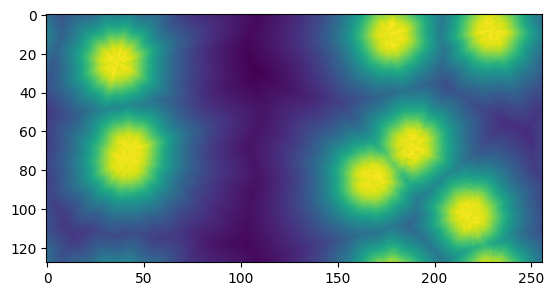

In [17]:
shape = np.array((128, 256))
ratio = shape/shape.min()
points = np.array([np.random.uniform(0, ratio[1], 8), np.random.uniform(0, ratio[0], 8)]).T
coordinates = np.array(np.meshgrid(np.linspace(0, ratio[1], shape[1]), np.linspace(0, ratio[0], shape[0])))
offsets = np.array(np.meshgrid([-ratio[1], 0, ratio[1]], [-ratio[0], 0, ratio[0]])).T.reshape((-1, 2))
distances = np.array([np.array([np.linalg.norm(coordinates - (point + offset).reshape((2, 1, 1)), axis = 0) for offset in offsets]).min(0) for point in points])
distances_argmin = np.array([np.array([np.linalg.norm(coordinates - (point + offset).reshape((2, 1, 1)), axis = 0) for offset in offsets]).argmin(0) for point in points])
angles = np.zeros_like(distances)
angles_offset = np.zeros_like(distances)
for index_angle in range(angles.shape[0]):
    amplitudes, frequencies, phases = np.random.uniform(0, 1, 32), np.random.randint(1, 16, 32), np.random.uniform(0, 2*np.pi, 32)
    for index_distance in np.unique(distances_argmin[index_angle]):
        indices = np.argwhere(distances_argmin[index_angle] == index_distance)
        angle = np.arctan2(*(coordinates*np.random.uniform(0.99, 1.01, coordinates.shape) - (points[index_angle] + offsets[index_distance]).reshape((2, 1, 1))))
        angle_offset = np.array([a*np.sin(f*angle + p) for a, f, p in zip(amplitudes, frequencies, phases)]).sum(0)
        angles[index_angle] = np.where(distances_argmin[index_angle] == index_distance, angle, angles[index_angle])
        angles_offset[index_angle] = np.where(distances_argmin[index_angle] == index_distance, angle_offset, angles_offset[index_angle])
plt.imshow(np.array([logistic(1/d, k = 0.25) + logistic(a/a.max(), L = 0.1, k = 0.5) for d, a in zip(distances, angles_offset)]).max(0))

In [18]:
for plume in plumes:
    amplitudes, frequencies, phases = np.random.uniform(0, 1, 32), np.random.randint(1, 32, 32), np.random.uniform(0, 2*np.pi, 32)
    plume_sin = np.array([a*np.sin(f*plume.angle + p) for a, f, p in zip(amplitudes, frequencies, phases)]).sum(0)
    plume_sin /= np.nanmax(plume_sin) - np.nanmin(plume_sin)
    plume.temperature = logistic(plume.strength/plume.distance, k = 0.05) + logistic(plume_sin*plume.strength/plume.distance, L = 0.05, k = 0.1)

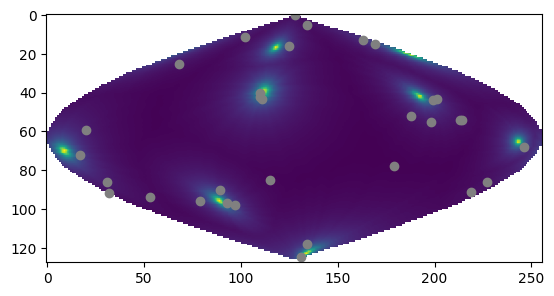

In [19]:
temperature = np.array([plume.temperature for plume in plumes]).max(0)
temperature -= np.nanmin(temperature)
temperature /= np.nanmax(temperature)
indices = np.argwhere(mask.flatten())[:, 0]
weights = temperature.flatten()[indices]
points = np.random.choice(indices, size = 32, p = weights/weights.sum(), replace = False)
plt.imshow(temperature/np.nansum(temperature))
for point in points:
    plt.scatter(*np.unravel_index(point, mask.shape)[::-1], color = "grey")

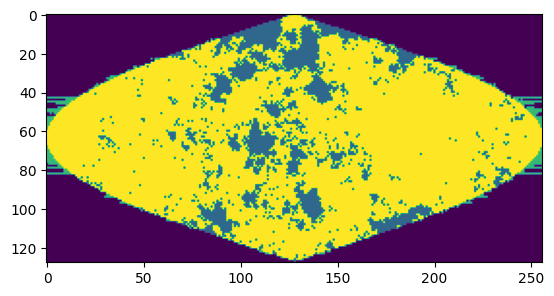

In [23]:
line = [np.unravel_index(points[1], shape = mask.shape)]
mask_line = np.zeros_like(mask)
for _ in range(100000):
    neighbourhood = generate_connectivity(line[-1], mask)
    weights_array = np.zeros((3, 3))
    for index_local, index_global in zip(np.array(np.meshgrid([-1, 0, 1], [-1, 0, 1])).T.reshape(-1, 2), neighbourhood):
        weights_array[*index_local] = np.where(~mask_line, temperature, 0)[*index_global]
    weights = np.nan_to_num(weights_array.flatten()[[0, 1, 2, 3, 5, 6, 7, 8]])
    if not weights.all():
        weights = np.ones_like(weights)
    line.append(neighbourhood[np.random.choice([0, 1, 2, 3, 5, 6, 7, 8], p = weights/weights.sum())])
    mask_line[*line[-1]] = True
plt.imshow(mask.astype(int) + 2*mask_line.astype(int))

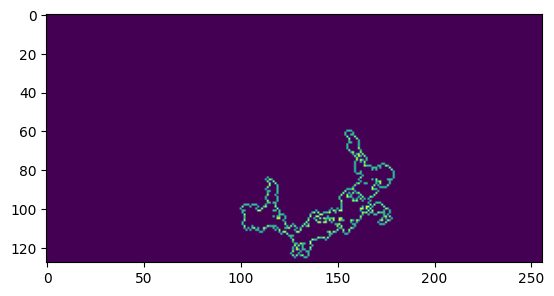

In [21]:
plt.imshow(np.where(~mask_line, np.linalg.norm(np.gradient(mask_line.astype(float)), axis = 0), 0))

In [99]:
from scipy.spatial.distance import cdist
rng = np.random.default_rng(0)
points = list(rng.uniform(-1, 1, (16, 2)))
# np.linalg.norm(points, axis = 1, keepdims = True)
distances = cdist(points, np.expand_dims(points[0], 0))[:, 0]
print(np.argsort(dist))

[ 0 12 15  7  5  6  8  9 11 14  3 10  1  2  4 13]


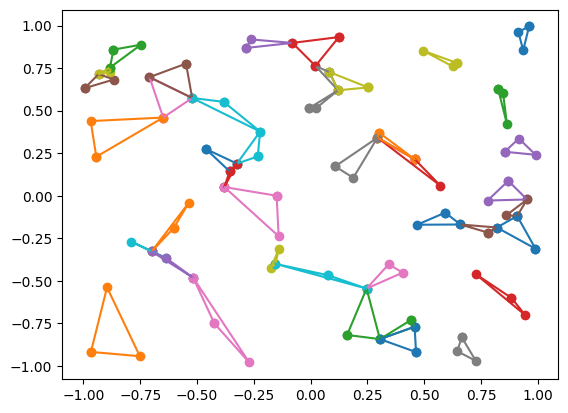

In [150]:
rng = np.random.default_rng(0)
points = rng.uniform(-1, 1, (90, 2)) # no. points must be a multiple of 3
point_indices = [index for index in range(points.shape[0])]
triangles = []
while len(point_indices):
    index_point = point_indices[0]
    distances = cdist(points, np.expand_dims(points[index_point], 0))[:, 0]
    triangle_indices = [index_point, *np.argsort(distances)[1:3]]
    triangles.append(triangle_indices)
    point_indices = [index for index in point_indices if index not in triangle_indices]

plt.figure()
for triangle in triangles:
    vertices = np.concatenate([points[triangle], np.expand_dims(points[triangle][0], axis = 0)], axis = 0)
    plt.scatter(vertices[:, 1], vertices[:, 0])
    plt.plot(vertices[:, 1], vertices[:, 0])
plt.show()

In [146]:
np.expand_dims(points[triangle][0], axis = 0).shape

(1, 2)

In [147]:
points[triangle].shape

(3, 2)

In [142]:
vertices[0]

array([0.72635784, 0.08292244])

In [131]:
points[triangle][:, 1]

array([ 0.08292244,  0.45899312, -0.46042657])